# Machine Learning Models

# Project Group #27
#### Clara Richter, Elise Rust, Yujia Jin
##### ANLY 502
##### Project Deliverable #3
#####Dec 5, 2022

The original dataset for this notebook is described in [The Pushshift Reddit Dataset](https://arxiv.org/pdf/2001.08435.pdf) paper.

### Review of the ML Business Questions

1) Predict the state of the economy from our dataset using regression
2) Classification of subreddits

##### To answer these questions we will build a few supervised Machine Learning Models:

1) Decision Tree and Gradient Boosted Tree Regression --> KPIs regression
2) Random Forest --> subreddit classification

##### Compare performance of two models/hyperparameter sets for each analysis

In [0]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressionModel, GBTRegressor
from sklearn.ensemble import RandomForestRegressor
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix # Confusion Matrix
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline, Model
from pyspark.sql import SparkSession
import pandas as pd

In [0]:
### Only run ONCE --> Change directory to root in order to load data and save plots, tables, models
import os
os.chdir("../..") # Move from code/ml up to root --> up two levels
print(os.getcwd())

/Workspace/Repos/yj234@georgetown.edu/fall-2022-reddit-big-data-project-project-group-27


### Load in training and testing data

Data previously cleaned in *code/ml/ML_Data_Prep.ipynb*
* title_KPIs = dataframe from submissions with vectorized text data + KPIs labels
* com_subred = dataframe from comments with vectorized text data + subreddit label

In [0]:
## Read in cleaned ML dataframes
## 1) dataset for predicting KPIs from posts
title_KPIs = spark.read.parquet("dbfs:/tmp/out/title_KPI.parquet")

## 2) Dataset for predicting subreddits from commments
com_subred = spark.read.parquet("dbfs:/tmp/out/com_subred1.parquet")

## 3) Dataset for predicting subreddits from titles
title_subred = spark.read.parquet("dbfs:/tmp/out/title_subred_data.parquet")

In [0]:
title_KPIs.show(5)

+--------+-----+----------+--------------------+
|     DOW|  CPI|Unemp_Rate|            features|
+--------+-----+----------+--------------------+
|29982.62|262.2|       6.4|(53194,[1,4,6,11,...|
|29982.62|262.2|       6.4|(53194,[0,3,4,6,1...|
|29982.62|262.2|       6.4|(53194,[4,5,7,29,...|
|29982.62|262.2|       6.4|(53194,[0,1,5,12,...|
|29982.62|262.2|       6.4|(53194,[2,5,7,12,...|
+--------+-----+----------+--------------------+
only showing top 5 rows



In [0]:
com_subred.show(5)

+---------+--------------------+
|subreddit|            features|
+---------+--------------------+
|democrats|(33365,[1,217,364...|
|democrats|(33365,[38,64,96,...|
|democrats|(33365,[58,59,242...|
|democrats|(33365,[59,86,196...|
|democrats|(33365,[0,39,67,7...|
+---------+--------------------+
only showing top 5 rows



In [0]:
title_subred.show(5)

+---------+--------------------+
|subreddit|            features|
+---------+--------------------+
| politics|(16325,[23,48,54,...|
| politics|(16325,[114,270,3...|
| politics|(16325,[0,67,346,...|
| politics|(16325,[0,8,551,1...|
| politics|(16325,[60,93,94,...|
+---------+--------------------+
only showing top 5 rows



In [0]:
### Ensure we're training on a balanced dataset --> equal numbers of each class to not skew the classification
com_subred.groupBy("subreddit").count().show()

+----------+-----+
| subreddit|count|
+----------+-----+
| democrats|40710|
|  politics|40710|
|Republican|40710|
+----------+-----+



In [0]:
title_subred.groupBy("subreddit").count().show()

+----------+-----+
| subreddit|count|
+----------+-----+
|  politics|13561|
|Republican|13561|
| democrats|13561|
+----------+-----+



### 1) Regression to predict KPIs from Reddit Text
* Decision Tree
* Gradient-Boosted Tree Regression

Of the KPIs (DOW, CPI, and Unemployment Rate), we've chosen to focus on the DOW index given the intertwining of the stock market and politics, and preliminary findings from our NLP analysis. DOW is measured by month and year, thus is a continuous value meriting regression analysis. Some texts will have the same DOW, depending on the time posted, but we opted to use regression rather than classification given the high number of unique DOW values in the dataset.

In [0]:
## Print schema of election data
title_KPIs.printSchema()

root
 |-- DOW: double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Unemp_Rate: double (nullable = true)
 |-- features: vector (nullable = true)



#### Split data into training and testing

In [0]:
#title_KPIs_small = title_KPIs.sample(0.01)
title_DOW = title_KPIs.select(['DOW','features'])

In [0]:
train_data, test_data = title_DOW.randomSplit([0.8, 0.2], 24)

print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))

Number of training records: 33657
Number of testing records : 8357


#### Build the model
* Note: The features in this subset don't need further ML transformations (i.e. OneHotEncoding) as they are already type float. 
* No features need to be converted to categorical variables either as we are doing regression.

#### Decision Tree Regression Model

Hyperparameters:
* Impurity = 'variance' (only option)
* maxDepth = 10 
* maxBins = 25

In [0]:
# Initialize Decision Tree multi-output classifier
dt = DecisionTreeRegressor(impurity='variance', labelCol="DOW", maxDepth=10, maxBins = 25, featuresCol="features")

In [0]:
## Train model on training data
dt_model = dt.fit(train_data)
#dt_model = dt_model.transform(train_data)

##### Visualize Feature Importance

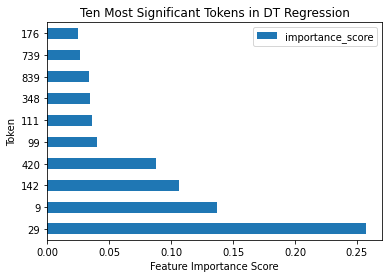

<Figure size 432x288 with 0 Axes>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt


# plot feature importance
token = []
importance_score = []

for i, val in enumerate(dt_model.featureImportances):
    token.append(i)
    importance_score.append(val)

feature_df = pd.DataFrame({'token':token, 'importance_score':importance_score})#.sort_value('importance_score')
feature_df = feature_df.nlargest(10, 'importance_score')
feature_df['token'] = pd.Categorical(feature_df.token)

feature_df.plot(kind='barh')
plt.xlabel('Feature Importance Score')
plt.ylabel('Token')
plt.title('Ten Most Significant Tokens in DT Regression')
plt.show()
plt.savefig("data/plots/ml/DT_Tokens.png") 

In [0]:
# Predict DOW values for testing data --> using the testing data for hyperparameter tuning
results = dt_model.transform(test_data)
results.show()

# Prepare dataframe for metrics evaluation
# Rename "DOW" to "label"
results = results.withColumnRenamed("DOW", "label")
results = results.select("features", "label", "prediction")

+--------+--------------------+------------------+
|     DOW|            features|        prediction|
+--------+--------------------+------------------+
|29982.62|(53194,[0,1,2,3,4...| 31272.15775728168|
|29982.62|(53194,[0,1,2,3,4...| 31272.15775728168|
|29982.62|(53194,[0,1,2,3,4...| 33723.62535634821|
|29982.62|(53194,[0,1,2,3,4...| 33723.62535634821|
|29982.62|(53194,[0,1,2,3,5...| 33037.35864988583|
|29982.62|(53194,[0,1,2,3,5...| 31272.15775728168|
|29982.62|(53194,[0,1,2,3,6...| 31272.15775728168|
|29982.62|(53194,[0,1,2,3,9...| 33037.35864988583|
|29982.62|(53194,[0,1,2,3,1...|30572.405537190152|
|29982.62|(53194,[0,1,2,3,1...| 31272.15775728168|
|29982.62|(53194,[0,1,2,4,5...| 33723.62535634821|
|29982.62|(53194,[0,1,2,4,5...|29982.620000000064|
|29982.62|(53194,[0,1,2,4,5...|          34529.45|
|29982.62|(53194,[0,1,2,4,5...| 31272.15775728168|
|29982.62|(53194,[0,1,2,4,6...|30455.188652482346|
|29982.62|(53194,[0,1,2,4,6...| 33723.62535634821|
|29982.62|(53194,[0,1,2,4,6...|

/databricks/spark/python/pyspark/sql/pandas/conversion.py:119: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


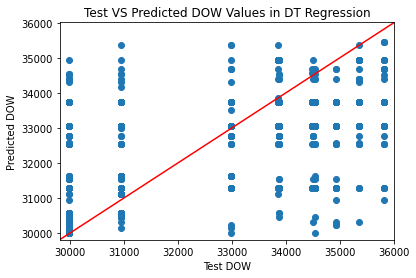

<Figure size 432x288 with 0 Axes>

In [0]:
results_pd = results.toPandas()
plt.scatter(results_pd.label,results_pd.prediction)
plt.xlim((29800, 36010)) # restricts x axis 
plt.ylim((29800, 36010)) # restricts y axis 
plt.plot([29800, 36010], [29800, 36010], color="red") # plots line y = x
plt.xlabel('Test DOW')
plt.ylabel('Predicted DOW')
plt.title('Test VS Predicted DOW Values in DT Regression')
plt.show()
plt.savefig("data/plots/ml/DT_Result.png")

#### Evaluate Model Performance

- Run model evaluation metrics (R2, MSE, RMSE, MAE) for regression
- Evaluate models using at least 2 different metrics and compare and interpret results

In [0]:
# Initialize evaluator object
evaluator = RegressionEvaluator()

## 1) Get R^2
print("R^2: ")
print(evaluator.evaluate(results, {evaluator.metricName: "r2"}))

## 2) Get MSE
print("MSE: ")
print(evaluator.evaluate(results,{evaluator.metricName: "mse"}))

## 3) Get Root Mean Squared Error
print("RMSE: ")
print(evaluator.evaluate(results, {evaluator.metricName: "rmse"}))

## 4) Get Mean Absolute Error
print("MAE: ")
print(evaluator.evaluate(results,
{evaluator.metricName: "mae"})
)

R^2: 
0.0921335973928723
MSE: 
3698751.5711778146
RMSE: 
1923.2138651688779
MAE: 
1539.063462164188


#### Gradient-Boosted Tree Regression
Hyperparameters:
* impurity: 'variance'
* lossType: 'squared'
* maxIter: 10 iterations
* stepSize: 0.15 (a.k.a. learning rate)
* maxDepth: 10

In [0]:
# Initialize Gradient Boosted Tree Regression Model
gb = GBTRegressor(labelCol="DOW", featuresCol="features", impurity="variance", lossType="squared", maxIter=10, stepSize=0.15, maxDepth=10)

In [0]:
## Train model on training data
gb_model = gb.fit(train_data)

In [0]:
# View key parameters of the model
print("Impurity: ", gb_model.getImpurity()) # Get impurity
print("Feature Subset Strategy: ", gb_model.getFeatureSubsetStrategy())

Impurity:  variance
Feature Subset Strategy:  all


##### Visualize Feature Importance

In [0]:
title_DOW.select("features").show()

+--------------------+
|            features|
+--------------------+
|(53194,[1,4,6,11,...|
|(53194,[0,3,4,6,1...|
|(53194,[4,5,7,29,...|
|(53194,[0,1,5,12,...|
|(53194,[2,5,7,12,...|
|(53194,[10,49,383...|
|(53194,[3,5,16,83...|
|(53194,[22993],[9...|
|(53194,[6,24,29,3...|
|(53194,[5307],[8....|
|(53194,[0,50,64,2...|
|(53194,[0,9,753,1...|
|(53194,[147,150,3...|
|(53194,[45,717,13...|
|(53194,[1,2,13,38...|
|(53194,[9,25,37,7...|
|(53194,[5,9,257,9...|
|(53194,[26,1998,7...|
|(53194,[6,7,16,22...|
|(53194,[8,16,27,1...|
+--------------------+
only showing top 20 rows



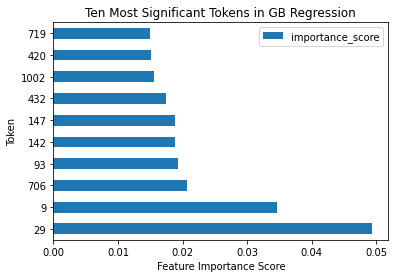

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt

# plot feature importance
token = []
importance_score = []

for i, val in enumerate(gb_model.featureImportances):
    token.append(i)
    importance_score.append(val)

feature_df = pd.DataFrame({'token':token, 'importance_score':importance_score})#.sort_value('importance_score')
feature_df = feature_df.nlargest(10, 'importance_score')
feature_df['token'] = pd.Categorical(feature_df.token)

feature_df.plot(kind='barh')
plt.xlabel('Feature Importance Score')
plt.ylabel('Token')
plt.title('Ten Most Significant Tokens in GB Regression')
plt.show()
plt.savefig("data/plots/ml/GB_Tokens.png")

In [0]:
# Predict DOW values for testing data --> using the testing data for hyperparameter tuning
results_gb = gb_model.transform(test_data)
results_gb.show()

# Prepare dataframe for metrics evaluation
# Rename "DOW" to "label"
results_gb = results_gb.withColumnRenamed("DOW", "label")
results_gb = results_gb.select("features", "label", "prediction")

+--------+--------------------+------------------+
|     DOW|            features|        prediction|
+--------+--------------------+------------------+
|29982.62|(53194,[0,1,2,3,4...|31263.219290370034|
|29982.62|(53194,[0,1,2,3,4...|30972.080395171506|
|29982.62|(53194,[0,1,2,3,4...| 33714.68688943657|
|29982.62|(53194,[0,1,2,3,4...| 33714.68688943657|
|29982.62|(53194,[0,1,2,3,5...| 33028.42018297419|
|29982.62|(53194,[0,1,2,3,5...|31263.219290370034|
|29982.62|(53194,[0,1,2,3,6...|31263.219290370034|
|29982.62|(53194,[0,1,2,3,9...| 33028.42018297419|
|29982.62|(53194,[0,1,2,3,1...|30563.467070278508|
|29982.62|(53194,[0,1,2,3,1...|31263.219290370034|
|29982.62|(53194,[0,1,2,4,5...| 33714.68688943657|
|29982.62|(53194,[0,1,2,4,5...| 29973.68153308842|
|29982.62|(53194,[0,1,2,4,5...| 34520.51153308836|
|29982.62|(53194,[0,1,2,4,5...|31263.219290370034|
|29982.62|(53194,[0,1,2,4,6...|  30446.2501855707|
|29982.62|(53194,[0,1,2,4,6...|33410.001379957066|
|29982.62|(53194,[0,1,2,4,6...|

/databricks/spark/python/pyspark/sql/pandas/conversion.py:119: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


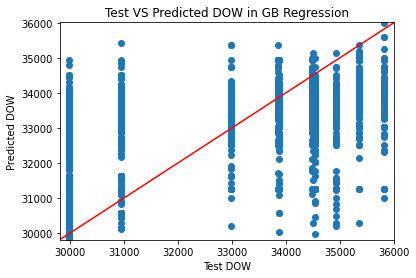

<Figure size 432x288 with 0 Axes>

In [0]:
results_gb_pd = results_gb.toPandas()
plt.scatter(results_gb_pd.label,results_gb_pd.prediction)
plt.xlim((29800, 36010)) # restricts x axis 
plt.ylim((29800, 36010)) # restricts y axis 
plt.plot([29800, 36010], [29800, 36010], color="red") # plots line y = x
plt.xlabel('Test DOW')
plt.ylabel('Predicted DOW')
plt.title('Test VS Predicted DOW in GB Regression')
plt.show()
plt.savefig("data/plots/ml/GB_Results.png")

##### Evaluate Model Performance

- Run model evaluation metrics (R2, MSE, RMSE, MAE) for regression
- Evaluate models using at least 2 different metrics and compare and interpret results

In [0]:
# Initialize evaluator object
evaluator2 = RegressionEvaluator()

## 1) Get R^2
print("R^2: ")
print(evaluator2.evaluate(results_gb, {evaluator2.metricName: "r2"}))

## 2) Get MSE
print("MSE: ")
print(evaluator2.evaluate(results_gb,{evaluator2.metricName: "mse"}))

## 3) Get Root Mean Squared Error
print("RMSE: ")
print(evaluator2.evaluate(results_gb, {evaluator2.metricName: "rmse"}))

## 4) Get Mean Absolute Error
print("MAE: ")
print(evaluator2.evaluate(results_gb,
{evaluator2.metricName: "mae"})
)

R^2: 
0.13255502799422758
MSE: 
3534070.039273261
RMSE: 
1879.9122424393277
MAE: 
1497.3668155819666


#### Comparison Across Regression Models --> Table #1

In [0]:
# Combine Regression Evaluation outcomes into a Table
r2 = [evaluator.evaluate(results, {evaluator.metricName: "r2"}), evaluator2.evaluate(results_gb, {evaluator2.metricName: "r2"})] 
mse = [evaluator.evaluate(results, {evaluator.metricName: "mse"}), evaluator2.evaluate(results_gb, {evaluator2.metricName: "mse"})]
rmse = [evaluator.evaluate(results, {evaluator.metricName: "rmse"}), evaluator2.evaluate(results_gb, {evaluator2.metricName: "rmse"})]
mae = [evaluator.evaluate(results, {evaluator.metricName: "mae"}), evaluator2.evaluate(results_gb, {evaluator2.metricName: "mae"})]
models=["Decision Tree", "Gradient Boost"]

# Combine into Table #1
regression_comp = pd.DataFrame(list(zip(r2, mse, rmse, mae)), columns=["R2", "MSE", "RMSE", "MAE"])
regression_comp.index = models

print(regression_comp)

                      R2           MSE         RMSE          MAE
Decision Tree   0.092134  3.698752e+06  1923.213865  1539.063462
Gradient Boost  0.132555  3.534070e+06  1879.912242  1497.366816


In [0]:
## Save comparison table to data/csvs/ml
regression_comp.to_csv("data/csv/ml/regression_comparison.csv")

### 2) Classification of subreddits using Random Forest Classifier

##### NOTE: We are using a pipeline for extra credit. This model/analysis is also where it actually makes sense to use ML transformations like StringIndexer and OneHotEncoding so we use those as well.

#### a) Subreddits with Comments

In [0]:
com_subred.printSchema()

root
 |-- subreddit: string (nullable = true)
 |-- features: vector (nullable = true)



#### Split data into training and testing

In [0]:
train_data, test_data = com_subred.randomSplit([0.8, 0.2], 24)

print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))

Number of training records: 97770
Number of testing records : 24360


#### Build the model

##### ML Transformations -->
* 1) StringIndexer
* 2) OneHotEncoding

In [0]:
# String indexer --> for the label (subreddit)
stringIndexer_subreddit = StringIndexer(inputCol="subreddit", outputCol="subreddit_ix")

In [0]:
# Examine the labels
stringIndexer_subreddit = stringIndexer_subreddit.fit(com_subred)

print(stringIndexer_subreddit.labels)

['Republican', 'democrats', 'politics']


In [0]:
# One hot encoding to convert our label subreddit with more than two levels
onehot_subreddit = OneHotEncoder(inputCol="subreddit_ix", outputCol="subreddit_vec")

#### Initialize Random Forest Model:

##### Three Hyperparameter Sets:
* Set 1: numTrees=1,000, impurity='gini', maxDepth=10, minInfoGain=5, seed=42
* Set 2: numTrees=500, impurity='entropy', maxDepth=NA, minInfoGain=10, seed=5

##### Hyperparameter Set #1

In [0]:
# Instantiate Random Forest Classifier #1
rf_1 = RandomForestClassifier(labelCol="subreddit_ix", featuresCol="features", numTrees=1000, impurity='gini', seed=42)

In [0]:
labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predictedSubreddit",
                               #labels=["r/politics", "r/republican", "r/democrats"]
                               labels=['Republican', 'democrats', 'politics'])

In [0]:
# Initialize pipeline! Combine the string indexer, one hot encoding, random forest model, and label converter into one sequential pipeline
pipeline_rf = Pipeline(stages=[stringIndexer_subreddit, 
                               onehot_subreddit,
                               rf_1, labelConverter])

#### Train Model --> Pipeline for extra credit

In [0]:
# First, fit the pipeline to the data. This step calculates the transformations, while transform() actually applies them to return a transformed dataframe
model_rf1 = pipeline_rf.fit(train_data)
model_rf1.transform(train_data)

Out[58]: DataFrame[subreddit: string, features: vector, subreddit_ix: double, subreddit_vec: vector, rawPrediction: vector, probability: vector, prediction: double, predictedSubreddit: string]

#### Evaluate Model Performance

- Run model evaluation metrics (Accuracy, Precision, Recall, F1, Confusion Matrix)
- Evaluate models using at least 2 different metrics and compare and interpret results

In [0]:
## Predict new labels
predictions = model_rf1.transform(test_data)

In [0]:
# Show output prediction dataframe
predictions.show()

+---------+--------------------+------------+-------------+--------------------+--------------------+----------+------------------+
|subreddit|            features|subreddit_ix|subreddit_vec|       rawPrediction|         probability|prediction|predictedSubreddit|
+---------+--------------------+------------+-------------+--------------------+--------------------+----------+------------------+
|democrats|(33365,[0,1,2,6,1...|         1.0|(2,[1],[1.0])|[277.503953419674...|[0.27750395341967...|       1.0|         democrats|
|democrats|(33365,[0,1,2,6,1...|         1.0|(2,[1],[1.0])|[272.222317295367...|[0.27222231729536...|       1.0|         democrats|
|democrats|(33365,[0,1,2,16,...|         1.0|(2,[1],[1.0])|[273.612323298661...|[0.27361232329866...|       1.0|         democrats|
|democrats|(33365,[0,1,2,16,...|         1.0|(2,[1],[1.0])|[283.836963623576...|[0.28383696362357...|       1.0|         democrats|
|democrats|(33365,[0,1,34,47...|         1.0|(2,[1],[1.0])|[298.699932978546

In [0]:
# Subset only relevant columns to examine the model outcomes
predictions_sub = predictions.select("subreddit_ix", "prediction")
predictions_sub

Out[61]: DataFrame[subreddit_ix: double, prediction: double]

In [0]:
# Look at prediction distribution to ensure there's no biased skew
predictions_sub.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       1.0| 7788|
|       2.0|14892|
|       0.0| 1680|
+----------+-----+



In [0]:
### Build a class to visualize a ROC Curve
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Out[64]: [<matplotlib.lines.Line2D at 0x7fd7f1aea1c0>]

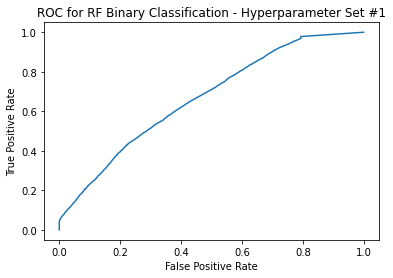

In [0]:
import matplotlib.pyplot as plt
# Create a Pipeline estimator and fit on train DF, predict on test DF
#model = estimator.fit(train)
predictions = model_rf1.transform(test_data)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('subreddit_ix','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['subreddit_ix'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC for RF Binary Classification - Hyperparameter Set #1')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

In [0]:
## 1) Accuracy
evaluatorRF = MulticlassClassificationEvaluator(labelCol="subreddit_ix", predictionCol="prediction", metricName="accuracy")
accuracy = evaluatorRF.evaluate(predictions)
print("Accuracy of the Random Forest classification model is: ", accuracy)

## 2) Precision
evaluatorRF = MulticlassClassificationEvaluator(labelCol="subreddit_ix", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluatorRF.evaluate(predictions)
print("Precision of the Random Forest classification model is: ", precision)

## 3) Recall
evaluatorRF = MulticlassClassificationEvaluator(labelCol="subreddit_ix", predictionCol="prediction", metricName="weightedRecall")
recall = evaluatorRF.evaluate(predictions)
print("Recall of the Random Forest classification model is: ", recall)

## 4) F-1 Score
evaluatorRF = MulticlassClassificationEvaluator(labelCol="subreddit_ix", predictionCol="prediction", metricName="f1")
f1 = evaluatorRF.evaluate(predictions)
print("F1 score of the Random Forest classification model is: ", f1)

Accuracy of the Random Forest classification model is:  0.4544334975369458
Precision of the Random Forest classification model is:  0.6163511897200651
Recall of the Random Forest classification model is:  0.45443349753694584
F1 score of the Random Forest classification model is:  0.43193227554533453


In [0]:
## 5) Confusion Matrix

y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("subreddit_ix").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1680 1992 4468]
 [   0 3543 4577]
 [   0 2253 5847]]


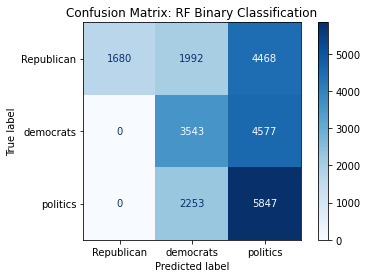

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

labels=['Republican', 'democrats', 'politics']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: RF Binary Classification")
plt.show()
plt.savefig("data/plots/ml/RF_CM1.png")

##### Hyperparameter Set #2
* numTrees=10, impurity='entropy', maxDepth=NA, minInfoGain=10, seed=5

In [0]:
# Initialize new RF with new hyperparameter set
rf_2 = RandomForestClassifier(labelCol="subreddit_ix", featuresCol="features", numTrees=500, impurity='entropy', seed=5)

In [0]:
# Re-initialize pipeline with new RF model
pipeline_rf_2 = Pipeline(stages=[stringIndexer_subreddit, 
                               onehot_subreddit,
                               rf_2, labelConverter])

#### Train Model --> Pipeline for extra credit

In [0]:
# Fit the pipeline to the data. This step calculates the transformations, while transform() actually applies them to return a transformed dataframe
model_rf_2 = pipeline_rf_2.fit(train_data)
model_rf_2.transform(train_data)

Out[70]: DataFrame[subreddit: string, features: vector, subreddit_ix: double, subreddit_vec: vector, rawPrediction: vector, probability: vector, prediction: double, predictedSubreddit: string]

#### Evaluate Model Performance

- Run model evaluation metrics (Accuracy, Precision, Recall, F1, Confusion Matrix)
- Evaluate models using at least 2 different metrics and compare and interpret results

In [0]:
## Predict new labels
predictions_2 = model_rf_2.transform(test_data)

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


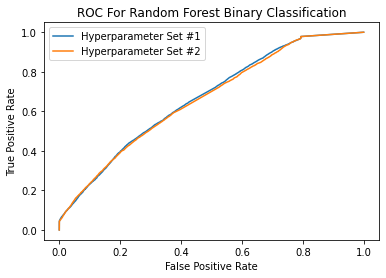

In [0]:
### ROC Curve for Hyperparameter Set #2 --> Compare ROC Curves across two models

# Returns as a list (false positive rate, true positive rate)
preds = predictions_2.select('subreddit_ix','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['subreddit_ix'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val2 = [x[0] for x in points]
y_val2 = [x[1] for x in points]
plt.title('ROC For Random Forest Binary Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val, label="Hyperparameter Set #1") # From hyperparameter set #2
plt.plot(x_val2, y_val2, label="Hyperparameter Set #2")
plt.legend()
plt.show()
#plt.savefig("data/plots/ml/ROC.png")

In [0]:
## 1) Accuracy
evaluatorRF = MulticlassClassificationEvaluator(labelCol="subreddit_ix", predictionCol="prediction", metricName="accuracy")
accuracy_2 = evaluatorRF.evaluate(predictions_2)
print("Accuracy of the Random Forest classification model is: ", accuracy_2)

## 2) Precision
evaluatorRF = MulticlassClassificationEvaluator(labelCol="subreddit_ix", predictionCol="prediction", metricName="weightedPrecision")
precision_2 = evaluatorRF.evaluate(predictions_2)
print("Precision of the Random Forest classification model is: ", precision_2)

## 3) Recall
evaluatorRF = MulticlassClassificationEvaluator(labelCol="subreddit_ix", predictionCol="prediction", metricName="weightedRecall")
recall_2 = evaluatorRF.evaluate(predictions_2)
print("Recall of the Random Forest classification model is: ", recall_2)

## 4) F-1 Score
evaluatorRF = MulticlassClassificationEvaluator(labelCol="subreddit_ix", predictionCol="prediction", metricName="f1")
f1_2 = evaluatorRF.evaluate(predictions_2)
print("F1 score of the Random Forest classification model is: ", f1_2)

Accuracy of the Random Forest classification model is:  0.4534893267651888
Precision of the Random Forest classification model is:  0.6178097500369916
Recall of the Random Forest classification model is:  0.4534893267651888
F1 score of the Random Forest classification model is:  0.4289505774110701


In [0]:
## 2) Confusion Matrix
y_pred=predictions_2.select("predictedSubreddit").collect()
y_orig=predictions_2.select("subreddit").collect()

cm_2 = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm_2)

Confusion Matrix:
[[1683 1792 4665]
 [   2 3269 4849]
 [   0 2005 6095]]


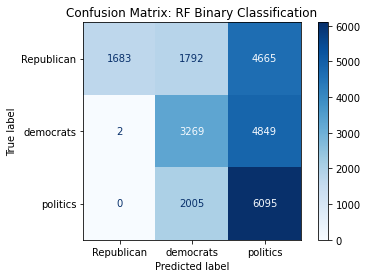

<Figure size 432x288 with 0 Axes>

In [0]:
labels=['Republican', 'democrats', 'politics']
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: RF Binary Classification")
plt.show()
plt.savefig("data/plots/ml/RF_CM2.png")

#### Comparison Across Classification Hyperparameter Sets --> Table #2

In [0]:
### Get table with accuracy, precision, recall, F1 for each model
accuracies = [accuracy, accuracy_2] 
recalls = [recall, recall_2]
precisions = [precision, precision_2]
f1s = [f1, f1_2]
models=["Hyperparameter Set #1", "Hyperparameter Set #2"]

# Combine into Table #1
classification_comp = pd.DataFrame(list(zip(accuracies, recalls, precisions, f1s)), columns=["Accuracy", "Recall", "Precision", "F1"])
classification_comp.index = models

print(classification_comp)

                       Accuracy    Recall  Precision        F1
Hyperparameter Set #1  0.454433  0.454433   0.616351  0.431932
Hyperparameter Set #2  0.453489  0.453489   0.617810  0.428951


In [0]:
## Save table to data/csvs/ml/
classification_comp.to_csv("data/csv/ml/classification_comparison.csv")

#### b) Subreddits with titles

In [0]:
title_subred.printSchema()

root
 |-- subreddit: string (nullable = true)
 |-- features: vector (nullable = true)



#### Split data into training and testing

In [0]:
train_data_title, test_data_title = title_subred.randomSplit([0.8, 0.2], 24)

print("Number of training records: " + str(train_data_title.count()))
print("Number of testing records : " + str(test_data_title.count()))

Number of training records: 32577
Number of testing records : 8106


#### Build the model

##### ML Transformations -->
* 1) StringIndexer
* 2) OneHotEncoding

In [0]:
# String indexer --> for the label (subreddit)
stringIndexer_subreddit = StringIndexer(inputCol="subreddit", outputCol="subreddit_ix")

In [0]:
# Examine the labels
stringIndexer_subreddit = stringIndexer_subreddit.fit(title_subred)

print(stringIndexer_subreddit.labels)

['Republican', 'democrats', 'politics']


In [0]:
# One hot encoding to convert our label subreddit with more than two levels
onehot_subreddit = OneHotEncoder(inputCol="subreddit_ix", outputCol="subreddit_vec")

#### Initialize Random Forest Model:

##### Three Hyperparameter Sets:
* Set 1: numTrees=1,000, impurity='gini', maxDepth=10, minInfoGain=5, seed=42
* Set 2: numTrees=500, impurity='entropy', maxDepth=NA, minInfoGain=10, seed=5

##### Hyperparameter Set #1

#### Train Model --> Pipeline for extra credit

In [0]:
# First, fit the pipeline to the data. This step calculates the transformations, while transform() actually applies them to return a transformed dataframe
model_rf1 = pipeline_rf.fit(train_data_title)
model_rf1.transform(train_data_title)

Out[83]: DataFrame[subreddit: string, features: vector, subreddit_ix: double, subreddit_vec: vector, rawPrediction: vector, probability: vector, prediction: double, predictedSubreddit: string]

#### Evaluate Model Performance

- Run model evaluation metrics (Accuracy, Precision, Recall, F1, Confusion Matrix)
- Evaluate models using at least 2 different metrics and compare and interpret results

In [0]:
## Predict new labels
predictions = model_rf1.transform(test_data_title)

In [0]:
# Show output prediction dataframe
predictions.show()

+---------+--------------------+------------+-------------+--------------------+--------------------+----------+------------------+
|subreddit|            features|subreddit_ix|subreddit_vec|       rawPrediction|         probability|prediction|predictedSubreddit|
+---------+--------------------+------------+-------------+--------------------+--------------------+----------+------------------+
| politics|(16325,[0,1,4,24,...|         2.0|    (2,[],[])|[330.133831320771...|[0.33013383132077...|       2.0|          politics|
| politics|(16325,[0,1,4,99,...|         2.0|    (2,[],[])|[332.601929965776...|[0.33260192996577...|       2.0|          politics|
| politics|(16325,[0,1,5,9,1...|         2.0|    (2,[],[])|[321.145436156322...|[0.32114543615632...|       2.0|          politics|
| politics|(16325,[0,1,6,57,...|         2.0|    (2,[],[])|[332.344348438286...|[0.33234434843828...|       2.0|          politics|
| politics|(16325,[0,1,16,26...|         2.0|    (2,[],[])|[333.617537280974

In [0]:
# Subset only relevant columns to examine the model outcomes
predictions_sub = predictions.select("subreddit_ix", "prediction")
predictions_sub

Out[86]: DataFrame[subreddit_ix: double, prediction: double]

In [0]:
# Look at prediction distribution to ensure there's no biased skew
predictions_sub.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 1946|
|       1.0| 3909|
|       2.0| 2251|
+----------+-----+



/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Out[88]: [<matplotlib.lines.Line2D at 0x7fd7f16ba1f0>]

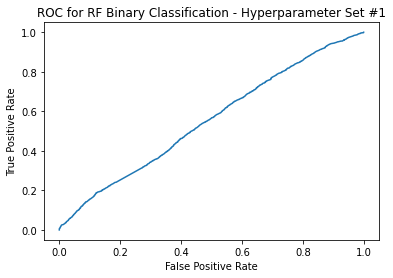

In [0]:
import matplotlib.pyplot as plt
# Create a Pipeline estimator and fit on train DF, predict on test DF
#model = estimator.fit(train)
predictions = model_rf1.transform(test_data_title)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('subreddit_ix','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['subreddit_ix'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC for RF Binary Classification - Hyperparameter Set #1')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

In [0]:
## 1) Accuracy
evaluatorRF = MulticlassClassificationEvaluator(labelCol="subreddit_ix", predictionCol="prediction", metricName="accuracy")
accuracy = evaluatorRF.evaluate(predictions)
print("Accuracy of the Random Forest classification model is: ", accuracy)

## 2) Precision
evaluatorRF = MulticlassClassificationEvaluator(labelCol="subreddit_ix", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluatorRF.evaluate(predictions)
print("Precision of the Random Forest classification model is: ", precision)

## 3) Recall
evaluatorRF = MulticlassClassificationEvaluator(labelCol="subreddit_ix", predictionCol="prediction", metricName="weightedRecall")
recall = evaluatorRF.evaluate(predictions)
print("Recall of the Random Forest classification model is: ", recall)

## 4) F-1 Score
evaluatorRF = MulticlassClassificationEvaluator(labelCol="subreddit_ix", predictionCol="prediction", metricName="f1")
f1 = evaluatorRF.evaluate(predictions)
print("F1 score of the Random Forest classification model is: ", f1)

Accuracy of the Random Forest classification model is:  0.5044411547002221
Precision of the Random Forest classification model is:  0.5195852809806736
Recall of the Random Forest classification model is:  0.5044411547002221
F1 score of the Random Forest classification model is:  0.4995990319258502


In [0]:
## 5) Confusion Matrix

y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("subreddit_ix").collect()

cm_3 = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm_3)

Confusion Matrix:
[[1066 1197  456]
 [ 356 1769  541]
 [ 524  943 1254]]


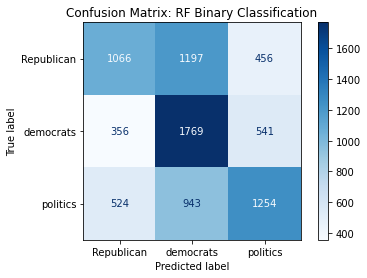

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

labels=['Republican', 'democrats', 'politics']
disp = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: RF Binary Classification")
plt.show()
plt.savefig("data/plots/ml/RF_TIT1.png")

##### Hyperparameter Set #2
* numTrees=10, impurity='entropy', maxDepth=NA, minInfoGain=10, seed=5

#### Train Model --> Pipeline for extra credit

In [0]:
# Fit the pipeline to the data. This step calculates the transformations, while transform() actually applies them to return a transformed dataframe
model_rf_2 = pipeline_rf_2.fit(train_data_title)
model_rf_2.transform(train_data_title)

Out[92]: DataFrame[subreddit: string, features: vector, subreddit_ix: double, subreddit_vec: vector, rawPrediction: vector, probability: vector, prediction: double, predictedSubreddit: string]

#### Evaluate Model Performance

- Run model evaluation metrics (Accuracy, Precision, Recall, F1, Confusion Matrix)
- Evaluate models using at least 2 different metrics and compare and interpret results

In [0]:
## Predict new labels
predictions_2 = model_rf_2.transform(test_data_title)

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


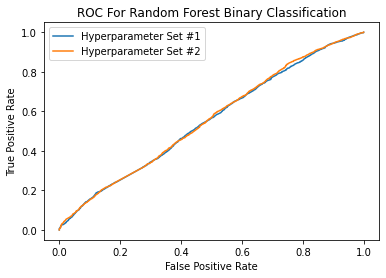

In [0]:
### ROC Curve for Hyperparameter Set #2 --> Compare ROC Curves across two models

# Returns as a list (false positive rate, true positive rate)
preds = predictions_2.select('subreddit_ix','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['subreddit_ix'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val2 = [x[0] for x in points]
y_val2 = [x[1] for x in points]
plt.title('ROC For Random Forest Binary Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val, label="Hyperparameter Set #1") # From hyperparameter set #2
plt.plot(x_val2, y_val2, label="Hyperparameter Set #2")
plt.legend()
plt.show()
#plt.savefig("data/plots/ml/ROC.png")

In [0]:
## 1) Accuracy
evaluatorRF = MulticlassClassificationEvaluator(labelCol="subreddit_ix", predictionCol="prediction", metricName="accuracy")
accuracy_2 = evaluatorRF.evaluate(predictions_2)
print("Accuracy of the Random Forest classification model is: ", accuracy_2)

## 2) Precision
evaluatorRF = MulticlassClassificationEvaluator(labelCol="subreddit_ix", predictionCol="prediction", metricName="weightedPrecision")
precision_2 = evaluatorRF.evaluate(predictions_2)
print("Precision of the Random Forest classification model is: ", precision_2)

## 3) Recall
evaluatorRF = MulticlassClassificationEvaluator(labelCol="subreddit_ix", predictionCol="prediction", metricName="weightedRecall")
recall_2 = evaluatorRF.evaluate(predictions_2)
print("Recall of the Random Forest classification model is: ", recall_2)

## 4) F-1 Score
evaluatorRF = MulticlassClassificationEvaluator(labelCol="subreddit_ix", predictionCol="prediction", metricName="f1")
f1_2 = evaluatorRF.evaluate(predictions_2)
print("F1 score of the Random Forest classification model is: ", f1_2)

Accuracy of the Random Forest classification model is:  0.4998766345916605
Precision of the Random Forest classification model is:  0.5187242280548852
Recall of the Random Forest classification model is:  0.49987663459166043
F1 score of the Random Forest classification model is:  0.49453083233956796


In [0]:
## 2) Confusion Matrix
y_pred=predictions_2.select("predictedSubreddit").collect()
y_orig=predictions_2.select("subreddit").collect()

cm_4 = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm_4)

Confusion Matrix:
[[1096 1247  376]
 [ 364 1802  500]
 [ 564 1003 1154]]


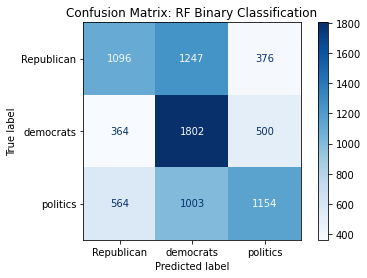

<Figure size 432x288 with 0 Axes>

In [0]:
labels=['Republican', 'democrats', 'politics']
disp = ConfusionMatrixDisplay(confusion_matrix=cm_4, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: RF Binary Classification")
plt.show()
plt.savefig("data/plots/ml/RF_CM4.png")

#### Comparison Across Classification Hyperparameter Sets --> Table #2

In [0]:
### Get table with accuracy, precision, recall, F1 for each model
accuracies = [accuracy, accuracy_2] 
recalls = [recall, recall_2]
precisions = [precision, precision_2]
f1s = [f1, f1_2]
models=["Hyperparameter Set #1", "Hyperparameter Set #2"]

# Combine into Table #1
classification_comp = pd.DataFrame(list(zip(accuracies, recalls, precisions, f1s)), columns=["Accuracy", "Recall", "Precision", "F1"])
classification_comp.index = models

print(classification_comp)

                       Accuracy    Recall  Precision        F1
Hyperparameter Set #1  0.504441  0.504441   0.519585  0.499599
Hyperparameter Set #2  0.499877  0.499877   0.518724  0.494531


In [0]:
## Save table to data/csvs/ml/
classification_comp.to_csv("data/csv/ml/classification_comparison_title.csv")

### Save model output and use for inference

In [0]:
dt_model.save("tmp/dt_model.h5")

In [0]:
# Display file in DBFS
display(dbutils.fs.ls("/tmp/dt_model.h5"))

path,name,size,modificationTime
dbfs:/tmp/dt_model.h5/data/,data/,0,1670290842000
dbfs:/tmp/dt_model.h5/metadata/,metadata/,0,1670290841000


### Test Loading Model Back In
And generate predictions with data

In [0]:
from pyspark.ml.regression import DecisionTreeRegressionModel

test_dt = DecisionTreeRegressionModel.load("/tmp/dt_model.h5")
test_dt

Out[102]: DecisionTreeRegressionModel: uid=DecisionTreeRegressor_2fe8c253231e, depth=10, numNodes=257, numFeatures=53194

In [0]:
results = test_dt.transform(test_data)
results.show()

+---------+--------------------+------------------+
|subreddit|            features|        prediction|
+---------+--------------------+------------------+
|democrats|(33365,[0,1,2,6,1...| 33723.62535634821|
|democrats|(33365,[0,1,2,6,1...| 35448.84666666668|
|democrats|(33365,[0,1,2,16,...|32523.755943060536|
|democrats|(33365,[0,1,2,16,...| 31272.15775728168|
|democrats|(33365,[0,1,34,47...| 33723.62535634821|
|democrats|(33365,[0,2,3,4,9...| 33037.35864988583|
|democrats|(33365,[0,3,6,8,9...| 33037.35864988583|
|democrats|(33365,[0,5,11,39...| 33723.62535634821|
|democrats|(33365,[0,5,17,26...| 31272.15775728168|
|democrats|(33365,[0,5,37,39...| 33723.62535634821|
|democrats|(33365,[0,6,10,14...| 34930.49330396484|
|democrats|(33365,[0,6,10,17...| 34483.72000000009|
|democrats|(33365,[0,6,12,14...| 33723.62535634821|
|democrats|(33365,[0,6,12,17...| 33723.62535634821|
|democrats|(33365,[0,6,13,17...| 33723.62535634821|
|democrats|(33365,[0,6,13,17...| 33723.62535634821|
|democrats|(